## Code for diversity regressions (fixed to use 'age at survey' rather than 'year birth')

Reference: https://academic.oup.com/ije/article/34/5/1089/645923?login=true

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import random

# import statsmodels.api as sm

# import statsmodels.formula.api as smf

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.preprocessing import StandardScaler

/gpfs/ycga/project/christakis/ajp65/conda_envs/TwinsUK/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Load full dataset

## Note: Because not including genetics, can use the full dataset

otu_table_point_001_percent_total_df = pd.read_csv("0.001_percent_total_otu_table.csv", header=0, index_col = 0).T
otu_table_point_001_percent_total = otu_table_point_001_percent_total_df.to_numpy()
row_sums = otu_table_point_001_percent_total.sum(axis=1)
otu_table_point_001_percent_total_relative = otu_table_point_001_percent_total / row_sums[:, np.newaxis]
n, p = otu_table_point_001_percent_total.shape
print("otu_table_point_001_percent_total.shape : ", n, p)


otu_table_point_001_percent_total.shape :  1627 1222


In [3]:
## Calculate Shannon diversities

shannon_diversities = np.zeros(n)
for i in range(0, n):
    p_i_nonzeros = otu_table_point_001_percent_total_relative[i, :][otu_table_point_001_percent_total_relative[i, :]>0]
    shannon_diversities[i] = -np.sum(p_i_nonzeros*np.log(p_i_nonzeros))


In [4]:
## Preprocessing

metadata = pd.read_csv('0.001_percent_total_sample_data.csv')
metadata['Shannon'] = shannon_diversities
metadata.rename(columns={'Unnamed: 0':'SampleID'}, inplace=True)
metadata = pd.get_dummies(metadata, columns=['SEX'], drop_first=True)

twin_pair_ids = []
for sample_id in metadata['SampleID']:
    twin_pair_ids.append(sample_id[:-1])
metadata['TwinPairID'] = twin_pair_ids
metadata['AGE_AT_SURVEY'] = 2008 - metadata['YEAR_BIRTH']

HEXACO_var_names = ['HEX_Honesty_Humility_corrected', 'Hex_Sincerity_corrected', 'Hex_Fairness_corrected', 'Hex_Greed_Avoidance_corrrected', 'Hex_Modesty_corrected', \
                       'HEX_Emotionality_corrected', 'Hex_Fearfulness_corrected', 'Hex_Anxiety_corrected', 'Hex_Dependence_corrected', 'Hex_Sentimentality_corrected', \
                       'HEX_Extraversion_corrected', 'Hex_Social_Self_Esteem_corrected', 'Hex_Social_Boldness_corrected', 'Hex_Sociability_corrected', 'Hex_Liveliness_corrected', \
                       'HEX_Agreeableness_corrected', 'Hex_Forgiveness_corrected', 'Hex_Gentleness_corrected', 'Hex_Flexibility_corrected', 'Hex_Patience_corrected', \
                       'HEX_Conscientiousness_corrected', 'Hex_Organization_corrected', 'Hex_Diligence_corrected', 'Hex_Perfectionism_corrected', 'Hex_Prudence_corrected', \
                       'HEX_Openness_corrected', 'Hex_Aesthetic_Appreciation_corrected', 'Hex_Inquistiveness_corrected', 'Hex_Creativity_corrected', 'Hex_Unconventionality_corrected']

fixed_effect_var_names = ['Shannon', 'AGE_AT_SURVEY', 'SEX_M']


variable_names_ordered = np.concatenate([['SampleID'], HEXACO_var_names, fixed_effect_var_names, ['TwinPairID']])

individuals_df = metadata[variable_names_ordered]
individuals_df = individuals_df.set_index('SampleID')

Y_full_df = metadata[HEXACO_var_names]
Y_full = Y_full_df.to_numpy()
covariates = metadata[['Shannon', 'AGE_AT_SURVEY', 'SEX_M']]

## Scale and center y variables
for y_var_name in HEXACO_var_names:
    individuals_df[y_var_name] = (individuals_df[y_var_name] - individuals_df[y_var_name].mean()) / individuals_df[y_var_name].std()

## Scale (but don't center) X fixed effect variables
for x_var_name in fixed_effect_var_names:
    individuals_df[x_var_name] = individuals_df[x_var_name] / individuals_df[x_var_name].std()

individuals_df = individuals_df.sort_index()

TUK_id_curr = individuals_df['TwinPairID'][0]
id_num = 0
id_nums = []
for i in range(0, len(individuals_df)):
    if (individuals_df['TwinPairID'][i] != TUK_id_curr):
        id_num += 1
        TUK_id_curr = individuals_df['TwinPairID'][i]
    id_nums.append(id_num)
    
if (len(list(set(individuals_df['TwinPairID']))) != id_num + 1):
    print("CHECK: Wrong number of twin pairs")
    
        
individuals_df['TwinID_num'] = np.array(id_nums)

individuals_df.to_csv('20220826_individuals_df.csv')


In [5]:
individuals_df['TwinPairID']

SampleID
TUK10055362    TUK1005536
TUK10141301    TUK1014130
TUK10182441    TUK1018244
TUK10451941    TUK1045194
TUK10451942    TUK1045194
                  ...    
TUK99682491    TUK9968249
TUK99682492    TUK9968249
TUK99691381    TUK9969138
TUK99691382    TUK9969138
TUK99914901    TUK9991490
Name: TwinPairID, Length: 1627, dtype: object

In [6]:
TwinPairIDs_duplicated = list(individuals_df[individuals_df['TwinPairID'].duplicated()]['TwinPairID'])
TwinPairIDs_duplicated
for TwinPairID_i in TwinPairIDs_duplicated:
    twin_genders = list(individuals_df[individuals_df['TwinPairID']==TwinPairID_i]['SEX_M'])
    if (twin_genders[0] != twin_genders[1]):
        print("Unmatched genders")
#     print(list(individuals_df[individuals_df['TwinPairID']==TwinPairID_i]['SEX_M']))

# individuals_df[individuals_df.index=='TUK10451942']['SEX_M']
# individuals_df[individuals_df['TwinPairID']=='TUK9969138']

### Code for model (1) in ref

In [7]:
## Regressions treating twins as individuals

regression_results = pd.read_csv('20220830_TwinsUK_DiversityRegressions_Results.csv')


params_shannon_individuals = regression_results['Ind_Coefficient'].to_numpy()
p_values_shannon_indivduals = regression_results['Ind_p'].to_numpy()


# for i in range(0, 30):
#     var_names_i = np.concatenate([[HEXACO_var_names[i]], fixed_effect_var_names, ['TwinPairID']])
    
#     individuals_df_i = individuals_df[var_names_i]
#     individuals_df_i = individuals_df_i.rename(columns={HEXACO_var_names[i]: "y"})
#     individuals_df_i = individuals_df_i.dropna(subset=['y'])
#     individuals_df_i['y'] = individuals_df_i['y'] - individuals_df_i['y'].mean()
# #     display(individuals_df_i)
    
# #     vc = {'TwinPairID': '0 + C(TwinPairID)'}
    
#     model = sm.MixedLM.from_formula('y ~ Shannon + AGE_AT_SURVEY + SEX_M', groups=individuals_df_i['TwinPairID'], data = individuals_df_i)
#     result = model.fit()
#     print("Results summary for " + HEXACO_var_names[i])
#     print(result.summary())
    
# #     >>> MixedLM.from_formula('test_score ~ age', vc_formula=vc,                                   re_formula='1', groups='school', data=data)
    
# #     non_nan = ~np.isnan(Y_full[:, i])
# #     print(len(non_nan))
# #     y = np.array(Y_full[:, i][non_nan])
# #     print(len(y))
# #     X = np.array(covariates[non_nan])
# #     print(len(X))
# #     groups = np.array(metadata['TwinPairID'][non_nan])
# # #     print(list(groups))
# #     print(len(groups))
    
# # #     groups = metadata['TwinPairID'][non_nan]

# #     y = (y - np.mean(y))
# #     df = pd.DataFrame(y, columns=["y"])
# #     df[fixed_effect_var_names] = X
# #     df['SampleID'] = np.array(metadata['SampleID'][non_nan])
# #     df = df.set_index('SampleID')
# # #     display(df)
    
# # #     free = MixedLMParams.from_components(
# # #                  fe_params=np.ones(exog.shape[1]),
# # #                  cov_re=np.eye(exog_re.shape[1]))
# #     print('\nRegression for ' + Y_full_df.columns[i])
# #     model = sm.MixedLM(df["y"], df[fixed_effect_var_names], groups)
# #     result = model.fit()
# #     print('Summary:\n', result.summary())

# #     result = model.fit()
#     p_values_shannon_indivduals.append(result.pvalues['Shannon'])
#     params_shannon_individuals.append(result.params['Shannon'])
    
# print("p values     : \n", p_values_shannon_indivduals)
# print("Coefficients : \n", params_shannon_individuals)

In [8]:
## Perform hypothesis tests

p_values = p_values_shannon_indivduals
alpha_bonferroni = 0.05 / 6
accept_reject = []

for i in range(0, len(p_values)):
    if (p_values[i] <= alpha_bonferroni):
        print("Reject H0: ", p_values[i], " < ",alpha_bonferroni, " = alpha")
        if (p_values[i] <= 0.001):
            accept_reject.append('reject_***')
        else:
            accept_reject.append('reject_**')
    else:
        print("Accept H0: ", p_values[i], " < ", alpha_bonferroni, " = alpha")
        accept_reject.append('accept')
accept_reject

Accept H0:  0.746308  <  0.008333333333333333  = alpha
Accept H0:  0.6121  <  0.008333333333333333  = alpha
Accept H0:  0.673  <  0.008333333333333333  = alpha
Reject H0:  0.00501  <  0.008333333333333333  = alpha
Accept H0:  0.6433  <  0.008333333333333333  = alpha
Accept H0:  0.38558  <  0.008333333333333333  = alpha
Accept H0:  0.806  <  0.008333333333333333  = alpha
Accept H0:  0.13203  <  0.008333333333333333  = alpha
Accept H0:  0.335331  <  0.008333333333333333  = alpha
Accept H0:  0.64079  <  0.008333333333333333  = alpha
Reject H0:  0.00704  <  0.008333333333333333  = alpha
Reject H0:  0.004765  <  0.008333333333333333  = alpha
Accept H0:  0.0884  <  0.008333333333333333  = alpha
Accept H0:  0.4784  <  0.008333333333333333  = alpha
Accept H0:  0.0366  <  0.008333333333333333  = alpha
Accept H0:  0.0493  <  0.008333333333333333  = alpha
Accept H0:  0.05  <  0.008333333333333333  = alpha
Accept H0:  0.289902  <  0.008333333333333333  = alpha
Accept H0:  0.39219  <  0.00833333333

['accept',
 'accept',
 'accept',
 'reject_**',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'reject_**',
 'reject_**',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'reject_**',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept',
 'accept']

In [9]:
twin_pair_results = pd.read_csv('20220830_TwinsUK_DiversityRegressions_Results.csv')
twin_pair_results

,HEXACO name,Ind_Coefficient,Ind_StdErr,Ind_p,all_B_Coefficient,all_B_StdErr,all_B_t,all_B_p,all_W_Coefficient,all_W_StdErr,...,DZ_B_Coefficient,DZ_B_StdErr,DZ_B_p,DZ_W_Coefficient,DZ_W_StdErr,DZ_W_p,Wald_p.2,B_compare_p,W_compare_p,Unnamed: 29
0,HEX_Honesty_Humility_corrected,0.008011,0.024760,0.746308,0.008842,0.030094,0.76894,0.768940,0.018560,0.029801,...,0.021076,0.044291,0.634382,0.003996,0.039996,0.920454,0.7800,0.7900,0.59,NaN
1,Hex_Sincerity_corrected,-0.012620,0.024880,0.612100,-0.017680,0.030070,-0.58800,0.556700,-0.016230,0.030000,...,-0.025860,0.044200,0.559000,-0.018720,0.039890,0.639000,0.9100,0.8200,0.93,NaN
2,Hex_Fairness_corrected,-0.010360,0.024550,0.673000,-0.006396,0.029996,-0.21300,0.831180,0.023845,0.029636,...,0.010070,0.044780,0.822210,0.011750,0.040560,0.772190,0.9800,0.9700,0.65,NaN
3,Hex_Greed_Avoidance_corrrected,0.068880,0.024510,0.005010,0.059670,0.029440,2.02700,0.042900,0.045490,0.029430,...,0.048840,0.043660,0.263840,0.033070,0.039590,0.404030,0.7900,0.5900,0.63,MISS
4,Hex_Modesty_corrected,0.011480,0.024780,0.643300,0.017700,0.029750,0.59500,0.551856,0.014180,0.029780,...,0.022520,0.043120,0.601640,0.011220,0.039230,0.774950,0.8500,0.8700,0.91,NaN
5,HEX_Emotionality_corrected,-0.021430,0.024690,0.385580,-0.018948,0.029943,-0.63300,0.527000,-0.008476,0.029700,...,-0.052080,0.044750,0.245070,-0.017690,0.039760,0.656536,0.5600,0.4500,0.78,NaN
6,Hex_Fearfulness_corrected,0.006073,0.024669,0.806000,0.021586,0.029629,0.72900,0.466000,0.000178,0.029793,...,-0.002176,0.043143,0.959790,0.018195,0.039149,0.642310,0.7800,0.6000,0.91,NaN
7,Hex_Anxiety_corrected,-0.037300,0.024750,0.132030,-0.044377,0.030230,-1.46800,0.142400,-0.002925,0.030012,...,-0.047790,0.045797,0.297000,-0.006455,0.041088,0.875000,0.5000,0.8900,0.94,NaN
8,Hex_Dependence_corrected,-0.023650,0.024540,0.335331,-0.025190,0.029520,-0.85300,0.393600,-0.020510,0.029460,...,-0.043880,0.043240,0.310710,-0.067430,0.039220,0.086180,0.6900,0.5000,0.63,NaN
9,Hex_Sentimentality_corrected,-0.011260,0.024120,0.640790,0.000038,0.029300,0.00100,0.998960,-0.007610,0.029100,...,-0.036910,0.043434,0.395830,0.001465,0.039032,0.970070,0.5400,0.8800,0.76,NaN


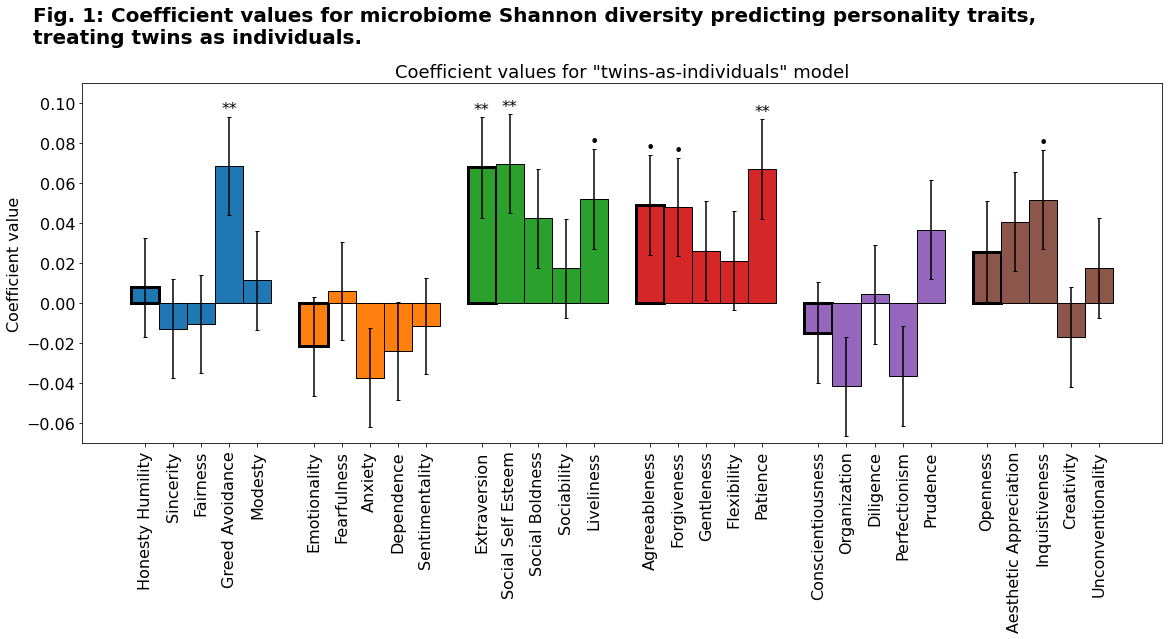

In [10]:
## Plot results from model (1) analyses

fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])

plt.title('Coefficient values for "twins-as-individuals" model', fontsize = 18)


HEXACO_var_names = ['Honesty Humility', 'Sincerity', 'Fairness', 'Greed Avoidance', 'Modesty', \
                       'Emotionality', 'Fearfulness', 'Anxiety', 'Dependence', 'Sentimentality', \
                       'Extraversion', 'Social Self Esteem', 'Social Boldness', 'Sociability', 'Liveliness', \
                       'Agreeableness', 'Forgiveness', 'Gentleness', 'Flexibility', 'Patience', \
                       'Conscientiousness', 'Organization', 'Diligence', 'Perfectionism', 'Prudence', \
                       'Openness', 'Aesthetic Appreciation', 'Inquistiveness', 'Creativity', 'Unconventionality']


# stderr_vals = [0.024760, 0.02488, 0.02455, 0.02451, 0.02478, \
#               0.02469, 0.024669, 0.02475, 0.02454, 0.02412, \
#               0.02519, 0.02472, 0.02487, 0.02472, 0.02488, \
#               0.02503, 0.02448, 0.02484, 0.02482, 0.02482, \
#               0.02518, 0.02476, 0.024787, 0.02492, 0.02487, \
#               0.025418, 0.02460, 0.02466, 0.02500, 0.02490]

stderr_vals_ind = list(twin_pair_results['Ind_StdErr'])

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

i = 0
for itr in range(0, len(params_shannon_individuals) + 5):
    if ((itr + 1) % 6 != 0):
        if (i % 5 == 0):
            rect = ax.bar(0.25*itr, params_shannon_individuals[i], color = colors[int(i / 5)], width = 0.25, edgecolor='black', yerr=stderr_vals_ind[i], capsize=2, linewidth=3)
        else:
            rect = ax.bar(0.25*itr, params_shannon_individuals[i], color = colors[int(i / 5)], width = 0.25, edgecolor='black', yerr=stderr_vals_ind[i], capsize=2)
        i += 1
        
label_locs = np.concatenate([np.arange(0, 1.25, 0.25), np.arange(1.5, 2.75, 0.25), np.arange(3, 4.25, 0.25), np.arange(4.5, 5.75, 0.25), np.arange(6, 7.25, 0.25), np.arange(7.5, 8.75, 0.25)])
plt.xticks(label_locs, HEXACO_var_names, rotation = 'vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Coefficient value', fontsize = 16)
plt.ylim([-0.07, 0.11])

i = 0
for i, rect in enumerate(ax.patches):
    symbol = ''
    if (p_values_shannon_indivduals[i] <= 0.001):
        symbol = '***'
    elif (p_values_shannon_indivduals[i] <= 0.05/6):
        symbol = '**'
    elif (p_values_shannon_indivduals[i] <= 0.05):
        symbol = '•'
        
    if (rect.get_height() >= 0):
        plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height() + stderr_vals_ind[i], symbol, ha='center', va='bottom', fontsize=16)
    elif (rect.get_height() < 0):
        plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height() - 0.012 - stderr_vals_ind[i], symbol, ha='center', va='bottom', fontsize=16)
    
    i += 1

plt.text(-1, 0.13, 'Fig. 1: Coefficient values for microbiome Shannon diversity predicting personality traits, \ntreating twins as individuals.', fontsize=20, fontweight='bold')
    
plt.savefig('20230320_DiversityRegressions_Individuals', bbox_inches='tight', dpi=400)


In [11]:
print(np.arange(0, 8.75, 0.25))
np.concatenate([np.arange(0, 1.25, 0.25), np.arange(1.5, 2.75, 0.25), np.arange(3, 4.25, 0.25), np.arange(4.5, 5.75, 0.25), np.arange(6, 7.25, 0.25), np.arange(7.5, 8.75, 0.25)])


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75 8.   8.25 8.5 ]


array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.5 , 1.75, 2.  , 2.25, 2.5 , 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.5 , 4.75, 5.  , 5.25, 5.5 , 6.  , 6.25,
       6.5 , 6.75, 7.  , 7.5 , 7.75, 8.  , 8.25, 8.5 ])

In [12]:
## Bonferroni

p_values = [0.745, 0.020, 0.007, 0.001, 0.072, 0.000, 0.072, 0.000, 0.012, 0.167, 0.602, 0.125, 0.014, 0.021, 0.508, 0.000, 0.079, 0.001, 0.001, 0.043, 0.644, 0.292, 0.754, 0.004, 0.365, 0.009, 0.004, 0.523, 0.137, 0.005, ]
alpha_bonferroni = 0.05 / 6

for i in range(0, len(p_values)):
    if (p_values[i] <= alpha_bonferroni):
        print("Reject H0: ", p_values[i], " < ",alpha_bonferroni, " = alpha")
    else:
        print("Accept H0: ", p_values[i], " < ", alpha_bonferroni, " = alpha")
len(p_values)



Accept H0:  0.745  <  0.008333333333333333  = alpha
Accept H0:  0.02  <  0.008333333333333333  = alpha
Reject H0:  0.007  <  0.008333333333333333  = alpha
Reject H0:  0.001  <  0.008333333333333333  = alpha
Accept H0:  0.072  <  0.008333333333333333  = alpha
Reject H0:  0.0  <  0.008333333333333333  = alpha
Accept H0:  0.072  <  0.008333333333333333  = alpha
Reject H0:  0.0  <  0.008333333333333333  = alpha
Accept H0:  0.012  <  0.008333333333333333  = alpha
Accept H0:  0.167  <  0.008333333333333333  = alpha
Accept H0:  0.602  <  0.008333333333333333  = alpha
Accept H0:  0.125  <  0.008333333333333333  = alpha
Accept H0:  0.014  <  0.008333333333333333  = alpha
Accept H0:  0.021  <  0.008333333333333333  = alpha
Accept H0:  0.508  <  0.008333333333333333  = alpha
Reject H0:  0.0  <  0.008333333333333333  = alpha
Accept H0:  0.079  <  0.008333333333333333  = alpha
Reject H0:  0.001  <  0.008333333333333333  = alpha
Reject H0:  0.001  <  0.008333333333333333  = alpha
Accept H0:  0.043  

30

## Results for model (2) in ref 
Note: These regression results were obtained from running code in 20220826_TwinsUKDiversityRegressions_R.Rmd

In [13]:
twin_pair_results = pd.read_csv('20220830_TwinsUK_DiversityRegressions_Results.csv')
twin_pair_results

,HEXACO name,Ind_Coefficient,Ind_StdErr,Ind_p,all_B_Coefficient,all_B_StdErr,all_B_t,all_B_p,all_W_Coefficient,all_W_StdErr,...,DZ_B_Coefficient,DZ_B_StdErr,DZ_B_p,DZ_W_Coefficient,DZ_W_StdErr,DZ_W_p,Wald_p.2,B_compare_p,W_compare_p,Unnamed: 29
0,HEX_Honesty_Humility_corrected,0.008011,0.024760,0.746308,0.008842,0.030094,0.76894,0.768940,0.018560,0.029801,...,0.021076,0.044291,0.634382,0.003996,0.039996,0.920454,0.7800,0.7900,0.59,NaN
1,Hex_Sincerity_corrected,-0.012620,0.024880,0.612100,-0.017680,0.030070,-0.58800,0.556700,-0.016230,0.030000,...,-0.025860,0.044200,0.559000,-0.018720,0.039890,0.639000,0.9100,0.8200,0.93,NaN
2,Hex_Fairness_corrected,-0.010360,0.024550,0.673000,-0.006396,0.029996,-0.21300,0.831180,0.023845,0.029636,...,0.010070,0.044780,0.822210,0.011750,0.040560,0.772190,0.9800,0.9700,0.65,NaN
3,Hex_Greed_Avoidance_corrrected,0.068880,0.024510,0.005010,0.059670,0.029440,2.02700,0.042900,0.045490,0.029430,...,0.048840,0.043660,0.263840,0.033070,0.039590,0.404030,0.7900,0.5900,0.63,MISS
4,Hex_Modesty_corrected,0.011480,0.024780,0.643300,0.017700,0.029750,0.59500,0.551856,0.014180,0.029780,...,0.022520,0.043120,0.601640,0.011220,0.039230,0.774950,0.8500,0.8700,0.91,NaN
5,HEX_Emotionality_corrected,-0.021430,0.024690,0.385580,-0.018948,0.029943,-0.63300,0.527000,-0.008476,0.029700,...,-0.052080,0.044750,0.245070,-0.017690,0.039760,0.656536,0.5600,0.4500,0.78,NaN
6,Hex_Fearfulness_corrected,0.006073,0.024669,0.806000,0.021586,0.029629,0.72900,0.466000,0.000178,0.029793,...,-0.002176,0.043143,0.959790,0.018195,0.039149,0.642310,0.7800,0.6000,0.91,NaN
7,Hex_Anxiety_corrected,-0.037300,0.024750,0.132030,-0.044377,0.030230,-1.46800,0.142400,-0.002925,0.030012,...,-0.047790,0.045797,0.297000,-0.006455,0.041088,0.875000,0.5000,0.8900,0.94,NaN
8,Hex_Dependence_corrected,-0.023650,0.024540,0.335331,-0.025190,0.029520,-0.85300,0.393600,-0.020510,0.029460,...,-0.043880,0.043240,0.310710,-0.067430,0.039220,0.086180,0.6900,0.5000,0.63,NaN
9,Hex_Sentimentality_corrected,-0.011260,0.024120,0.640790,0.000038,0.029300,0.00100,0.998960,-0.007610,0.029100,...,-0.036910,0.043434,0.395830,0.001465,0.039032,0.970070,0.5400,0.8800,0.76,NaN


In [14]:
## Code for preparing data for regressions in 20220826_TwinsUKDiversityRegressions_R.Rmd

has_twin = metadata['TwinPairID'].duplicated(keep=False)
metadata_twins = metadata[has_twin]

Y_full_twins_df = Y_full_df[has_twin]
Y_full_twins_df['SampleID'] = metadata_twins['SampleID']
covariates_twins = metadata_twins[['Shannon']]
covariates_twins['SampleID'] = metadata_twins['SampleID']

metadata_twins = metadata_twins.sort_values('SampleID')
Y_full_twins_df = Y_full_twins_df.sort_values('SampleID')
covariates_twins = covariates_twins.sort_values('SampleID')

metadata_twins = metadata_twins.set_index('SampleID')
Y_full_twins_df = Y_full_twins_df.set_index('SampleID')
covariates_twins = covariates_twins.set_index('SampleID')

print("metadata_twins shape", metadata_twins.shape)
print("Y_full_twins_df shape", Y_full_twins_df.shape)
print("covariates_twins shape", covariates_twins.shape)

zygosity_twins = metadata_twins[metadata_twins['TwinPairID'].duplicated(keep='first')]['ACTUAL_ZYGOSITY']
zygosity_individuals = metadata_twins['ACTUAL_ZYGOSITY']

print('zygosity_twins len', len(zygosity_twins))

# metadata_twins_dif = np.zeros((562, 82))
Y_full_twins_dif = np.zeros((562, 30))
covariates_twins_dif = np.zeros((1124, 1))
covariates_twins_mean = np.zeros((1124, 1))

itr = 0
for twin_pair_id in np.sort(list(set(metadata_twins['TwinPairID']))):
    twin_pair_id_1 = twin_pair_id + '1'
    twin_pair_id_2 = twin_pair_id + '2'
#     metadata_twins_dif[itr, :] = metadata_twins.loc[twin_pair_id_2, :] - metadata_twins.loc[twin_pair_id_1, :]
    
    
    Y_full_twins_dif[itr, :] = Y_full_twins_df.loc[twin_pair_id_2, :] - Y_full_twins_df.loc[twin_pair_id_1, :]

    

    covariates_twins_mean[2*itr, 0] = covariates_twins_mean[2*itr+1, 0] = (covariates_twins.loc[twin_pair_id_2, 'Shannon'] + covariates_twins.loc[twin_pair_id_1, 'Shannon']) / 2
    
    covariates_twins_dif[2*itr, 0] = covariates_twins.loc[twin_pair_id_1, 'Shannon'] - covariates_twins_mean[2*itr, 0]
    covariates_twins_dif[2*itr+1, 0] = covariates_twins.loc[twin_pair_id_2, 'Shannon'] - covariates_twins_mean[2*itr, 0]

    
    itr += 1
    
TwinPairIDs = np.sort(list(set(metadata_twins['TwinPairID'])))
    
covariates_twins_dif_df = pd.DataFrame(covariates_twins_dif)
covariates_twins_dif_df.columns = ['Shannon_dif']
covariates_twins_dif_df['SampleID'] = list(Y_full_twins_df.index)
covariates_twins_dif_df = covariates_twins_dif_df.set_index('SampleID')


covariates_twins_mean_df = pd.DataFrame(covariates_twins_mean)
covariates_twins_mean_df.columns = ['Shannon_mean']
covariates_twins_mean_df['SampleID'] = list(Y_full_twins_df.index)
covariates_twins_mean_df = covariates_twins_mean_df.set_index('SampleID')

# covariates_twins_dif_all_df = pd.DataFrame(covariates_twins_dif_all)
# covariates_twins_dif_all_df.columns = ['Shannon_dif']


# zygosity_twins['TwinPairID'] = np.sort(list(set(metadata_twins['TwinPairID'])))
# zygosity_twins = zygosity_twins.set_index('TwinPairID')
covariates_twins_mean_df["Shannon_dif"] = covariates_twins_dif

# display(metadata_twins)

covariates_twins_mean_df["Sex"] = metadata_twins["SEX_M"]
covariates_twins_mean_df["Age"] = metadata_twins["AGE_AT_SURVEY"]
covariates_twins_mean_df



full_twins_df = Y_full_twins_df
full_twins_df['Shannon'] = metadata_twins['Shannon']
full_twins_df[['Shannon_mean', 'Shannon_dif', 'Sex', 'Age']] = covariates_twins_mean_df

HEXACO_var_names = ['HEX_Honesty_Humility_corrected', 'Hex_Sincerity_corrected', 'Hex_Fairness_corrected', 'Hex_Greed_Avoidance_corrrected', 'Hex_Modesty_corrected', \
                       'HEX_Emotionality_corrected', 'Hex_Fearfulness_corrected', 'Hex_Anxiety_corrected', 'Hex_Dependence_corrected', 'Hex_Sentimentality_corrected', \
                       'HEX_Extraversion_corrected', 'Hex_Social_Self_Esteem_corrected', 'Hex_Social_Boldness_corrected', 'Hex_Sociability_corrected', 'Hex_Liveliness_corrected', \
                       'HEX_Agreeableness_corrected', 'Hex_Forgiveness_corrected', 'Hex_Gentleness_corrected', 'Hex_Flexibility_corrected', 'Hex_Patience_corrected', \
                       'HEX_Conscientiousness_corrected', 'Hex_Organization_corrected', 'Hex_Diligence_corrected', 'Hex_Perfectionism_corrected', 'Hex_Prudence_corrected', \
                       'HEX_Openness_corrected', 'Hex_Aesthetic_Appreciation_corrected', 'Hex_Inquistiveness_corrected', 'Hex_Creativity_corrected', 'Hex_Unconventionality_corrected']

## Scale and center y variables
for y_var_name in HEXACO_var_names:
    full_twins_df[y_var_name] = (full_twins_df[y_var_name] - full_twins_df[y_var_name].mean()) / full_twins_df[y_var_name].std()

## Scale (but don't center) x variables
for x_var_name in ['Shannon', 'Shannon_mean', 'Shannon_dif', 'Sex', 'Age']:
    full_twins_df[x_var_name] = full_twins_df[x_var_name] / full_twins_df[x_var_name].std()

full_twins_df[zygosity_individuals=="MZ"]
    

    
full_twins_df[zygosity_individuals=="MZ"].to_csv("20220830_MZ_df.csv")
full_twins_df[zygosity_individuals=="DZ"].to_csv("20220830_DZ_df.csv")

full_twins_df["MZ_indicator"] = np.where(zygosity_individuals=="MZ", 1, 0)

full_twins_df.to_csv("20220830_MZ_DZ_df.csv")




/tmp/ipykernel_20847/3186843623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_full_twins_df['SampleID'] = metadata_twins['SampleID']
/tmp/ipykernel_20847/3186843623.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covariates_twins['SampleID'] = metadata_twins['SampleID']


metadata_twins shape (1124, 82)
Y_full_twins_df shape (1124, 30)
covariates_twins shape (1124, 1)
zygosity_twins len 562


In [15]:
print(len(full_twins_df[zygosity_individuals=="MZ"])/2, len(full_twins_df[zygosity_individuals=="MZ"]))
print(len(full_twins_df[zygosity_individuals=="DZ"])/2, len(full_twins_df[zygosity_individuals=="DZ"]))

298.0 596
264.0 528


### Code for model (2) in ref

In [16]:
# ## Regressions on twin pairs (MZ and DZ together)

# p_values_Shannon_mean = []
# params_Shannon_mean = []
# p_values_shannon_dif_from_mean = []
# params_shannon_dif_from_mean = []


# for i in range(0, 30):
#     Y_full_has_twin = Y_full_twins_df.to_numpy()
#     non_nan = ~np.isnan(Y_full_has_twin[:, i])
#     y = Y_full_has_twin[:, i][non_nan]
#     X = covariates_twins_mean_df[non_nan]

#     y = y - np.mean(y)

#     print('\nRegression for ' + Y_full_df.columns[i])
#     model = sm.OLS(y, X)
#     result = model.fit()
#     print('Summary:\n', result.summary())
#     p_values_Shannon_mean.append(result.pvalues['Shannon_mean'])
#     p_values_shannon_dif_from_mean.append(result.pvalues['Shannon_dif'])
#     params_Shannon_mean.append(result.params['Shannon_mean'])
#     params_shannon_dif_from_mean.append(result.params['Shannon_dif'])

#     result = model.fit()
    
#     if (result.params['Shannon_mean'] < 0 and result.params['Shannon_dif'] < 0):
#         wald_str = '-Shannon_mean = -Shannon_dif'
#     elif (result.params['Shannon_mean'] < 0 and result.params['Shannon_dif'] >= 0):
#         wald_str = '-Shannon_mean = Shannon_dif'
#     elif (result.params['Shannon_mean'] >= 0 and result.params['Shannon_dif'] < 0):
#         wald_str = 'Shannon_mean = -Shannon_dif'
#     else:
#         wald_str = 'Shannon_mean = Shannon_dif'
# #     print(wald_str)
#     wald_test = result.wald_test(wald_str) # joint test
#     print("\nWald test :")
#     print(wald_test)


In [17]:
# ## Model (2) 
# ## Regressions on twin pairs (MZ only)

# p_values_Shannon_mean_MZ = []
# params_Shannon_mean_MZ = []
# p_values_shannon_dif_from_mean_MZ = []
# params_shannon_dif_from_mean_MZ = []


# Y_full_twins_df_MZ          = Y_full_twins_df[zygosity_individuals=="MZ"]
# covariates_twins_mean_df_MZ = covariates_twins_mean_df[zygosity_individuals=="MZ"]


# for i in range(0, 30):
#     Y_full_has_twin_MZ = Y_full_twins_df_MZ.to_numpy()
#     non_nan = ~np.isnan(Y_full_has_twin_MZ[:, i])
#     y = Y_full_has_twin_MZ[:, i][non_nan]
#     X = covariates_twins_mean_df_MZ[non_nan]
#     print("X before standardization : ")
#     display(X)
#     for var_name in X.columns:
#         X[var_name] = X[var_name] / X[var_name].std()
#     print("X after standardization : ")
#     display(X)

#     y = (y - np.mean(y)) / np.std(y)

#     print('\nRegression for ' + Y_full_df.columns[i])
#     model = sm.OLS(y, X)
#     result = model.fit()
#     print('Summary:\n', result.summary())
#     p_values_Shannon_mean_MZ.append(result.pvalues['Shannon_mean'])
#     p_values_shannon_dif_from_mean_MZ.append(result.params['Shannon_dif'])
#     params_Shannon_mean_MZ.append(result.pvalues['Shannon_mean'])
#     params_shannon_dif_from_mean_MZ.append(result.params['Shannon_dif'])
#     print("normalized_cov_params : ", np.sqrt(result.normalized_cov_params.iloc[0, 0]))

# #     result = model.fit()
#     if (result.params['Shannon_mean'] < 0 and result.params['Shannon_dif'] < 0):
#         wald_str = '-Shannon_mean = -Shannon_dif'
#     elif (result.params['Shannon_mean'] < 0 and result.params['Shannon_dif'] >= 0):
#         wald_str = '-Shannon_mean = Shannon_dif'
#     elif (result.params['Shannon_mean'] >= 0 and result.params['Shannon_dif'] < 0):
#         wald_str = 'Shannon_mean = -Shannon_dif'
#     else:
#         wald_str = 'Shannon_mean = Shannon_dif'
# #     print(wald_str)
#     wald_test = result.wald_test(wald_str) # joint test
#     print("\nWald test of |\Beta_W| = |\Beta_B| :")
#     print(wald_test)

In [18]:
# ## Model (2) 
# ## Regressions on twin pairs (DZ only)

# p_values_Shannon_mean_DZ = []
# params_Shannon_mean_DZ = []
# p_values_shannon_dif_from_mean_DZ = []
# params_shannon_dif_from_mean_DZ = []


# Y_full_twins_df_DZ          = Y_full_twins_df[zygosity_individuals=="DZ"]
# covariates_twins_mean_df_DZ = covariates_twins_mean_df[zygosity_individuals=="DZ"]


# for i in range(0, 30):
#     Y_full_has_twin_DZ = Y_full_twins_df_DZ.to_numpy()
#     non_nan = ~np.isnan(Y_full_has_twin_DZ[:, i])
#     y = Y_full_has_twin_DZ[:, i][non_nan]
#     X = covariates_twins_mean_df_DZ[non_nan]

#     y = y - np.mean(y)

#     print('\nRegression for ' + Y_full_df.columns[i])
#     model = sm.OLS(y, X)
#     result = model.fit()
#     print('Summary:\n', result.summary())
#     p_values_Shannon_mean_DZ.append(result.pvalues['Shannon_mean'])
#     p_values_shannon_dif_from_mean_DZ.append(result.params['Shannon_dif'])
#     params_Shannon_mean_DZ.append(result.pvalues['Shannon_mean'])
#     params_shannon_dif_from_mean_DZ.append(result.params['Shannon_dif'])
    

# #     result = model.fit()
#     wald_str = 'Shannon_mean = Shannon_dif'
# #     print(wald_str)
#     wald_test = result.wald_test(wald_str) # joint test
#     print("\nWald test :")
#     print(wald_test)


In [19]:
# ## Perform hypothesis tests

# # p_values = p_values_Shannon_mean
# # alpha_bonferroni = 0.05 / 6
# # accept_reject = []

# # for i in range(0, len(p_values)):
# #     if (p_values[i] <= alpha_bonferroni):
# #         print("Reject H0: ", p_values[i], " < ",alpha_bonferroni, " = alpha")
# #         accept_reject.append('reject')
# #     else:
# #         print("Accept H0: ", p_values[i], " < ", alpha_bonferroni, " = alpha")
# #         accept_reject.append('accept')
# # accept_reject

# # ## Perform hypothesis tests

# p_values = p_values_shannon_dif_from_mean
# alpha_bonferroni = 0.05 / 6
# accept_reject = []

# for i in range(0, len(p_values)):
#     if (p_values[i] <= alpha_bonferroni):
#         print("Reject H0: ", p_values[i], " < ",alpha_bonferroni, " = alpha")
#         accept_reject.append('reject')
#     else:
#         print("Accept H0: ", p_values[i], " < ", alpha_bonferroni, " = alpha")
#         accept_reject.append('accept')
# accept_reject

twin_pair_results

,HEXACO name,Ind_Coefficient,Ind_StdErr,Ind_p,all_B_Coefficient,all_B_StdErr,all_B_t,all_B_p,all_W_Coefficient,all_W_StdErr,...,DZ_B_Coefficient,DZ_B_StdErr,DZ_B_p,DZ_W_Coefficient,DZ_W_StdErr,DZ_W_p,Wald_p.2,B_compare_p,W_compare_p,Unnamed: 29
0,HEX_Honesty_Humility_corrected,0.008011,0.024760,0.746308,0.008842,0.030094,0.76894,0.768940,0.018560,0.029801,...,0.021076,0.044291,0.634382,0.003996,0.039996,0.920454,0.7800,0.7900,0.59,NaN
1,Hex_Sincerity_corrected,-0.012620,0.024880,0.612100,-0.017680,0.030070,-0.58800,0.556700,-0.016230,0.030000,...,-0.025860,0.044200,0.559000,-0.018720,0.039890,0.639000,0.9100,0.8200,0.93,NaN
2,Hex_Fairness_corrected,-0.010360,0.024550,0.673000,-0.006396,0.029996,-0.21300,0.831180,0.023845,0.029636,...,0.010070,0.044780,0.822210,0.011750,0.040560,0.772190,0.9800,0.9700,0.65,NaN
3,Hex_Greed_Avoidance_corrrected,0.068880,0.024510,0.005010,0.059670,0.029440,2.02700,0.042900,0.045490,0.029430,...,0.048840,0.043660,0.263840,0.033070,0.039590,0.404030,0.7900,0.5900,0.63,MISS
4,Hex_Modesty_corrected,0.011480,0.024780,0.643300,0.017700,0.029750,0.59500,0.551856,0.014180,0.029780,...,0.022520,0.043120,0.601640,0.011220,0.039230,0.774950,0.8500,0.8700,0.91,NaN
5,HEX_Emotionality_corrected,-0.021430,0.024690,0.385580,-0.018948,0.029943,-0.63300,0.527000,-0.008476,0.029700,...,-0.052080,0.044750,0.245070,-0.017690,0.039760,0.656536,0.5600,0.4500,0.78,NaN
6,Hex_Fearfulness_corrected,0.006073,0.024669,0.806000,0.021586,0.029629,0.72900,0.466000,0.000178,0.029793,...,-0.002176,0.043143,0.959790,0.018195,0.039149,0.642310,0.7800,0.6000,0.91,NaN
7,Hex_Anxiety_corrected,-0.037300,0.024750,0.132030,-0.044377,0.030230,-1.46800,0.142400,-0.002925,0.030012,...,-0.047790,0.045797,0.297000,-0.006455,0.041088,0.875000,0.5000,0.8900,0.94,NaN
8,Hex_Dependence_corrected,-0.023650,0.024540,0.335331,-0.025190,0.029520,-0.85300,0.393600,-0.020510,0.029460,...,-0.043880,0.043240,0.310710,-0.067430,0.039220,0.086180,0.6900,0.5000,0.63,NaN
9,Hex_Sentimentality_corrected,-0.011260,0.024120,0.640790,0.000038,0.029300,0.00100,0.998960,-0.007610,0.029100,...,-0.036910,0.043434,0.395830,0.001465,0.039032,0.970070,0.5400,0.8800,0.76,NaN


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


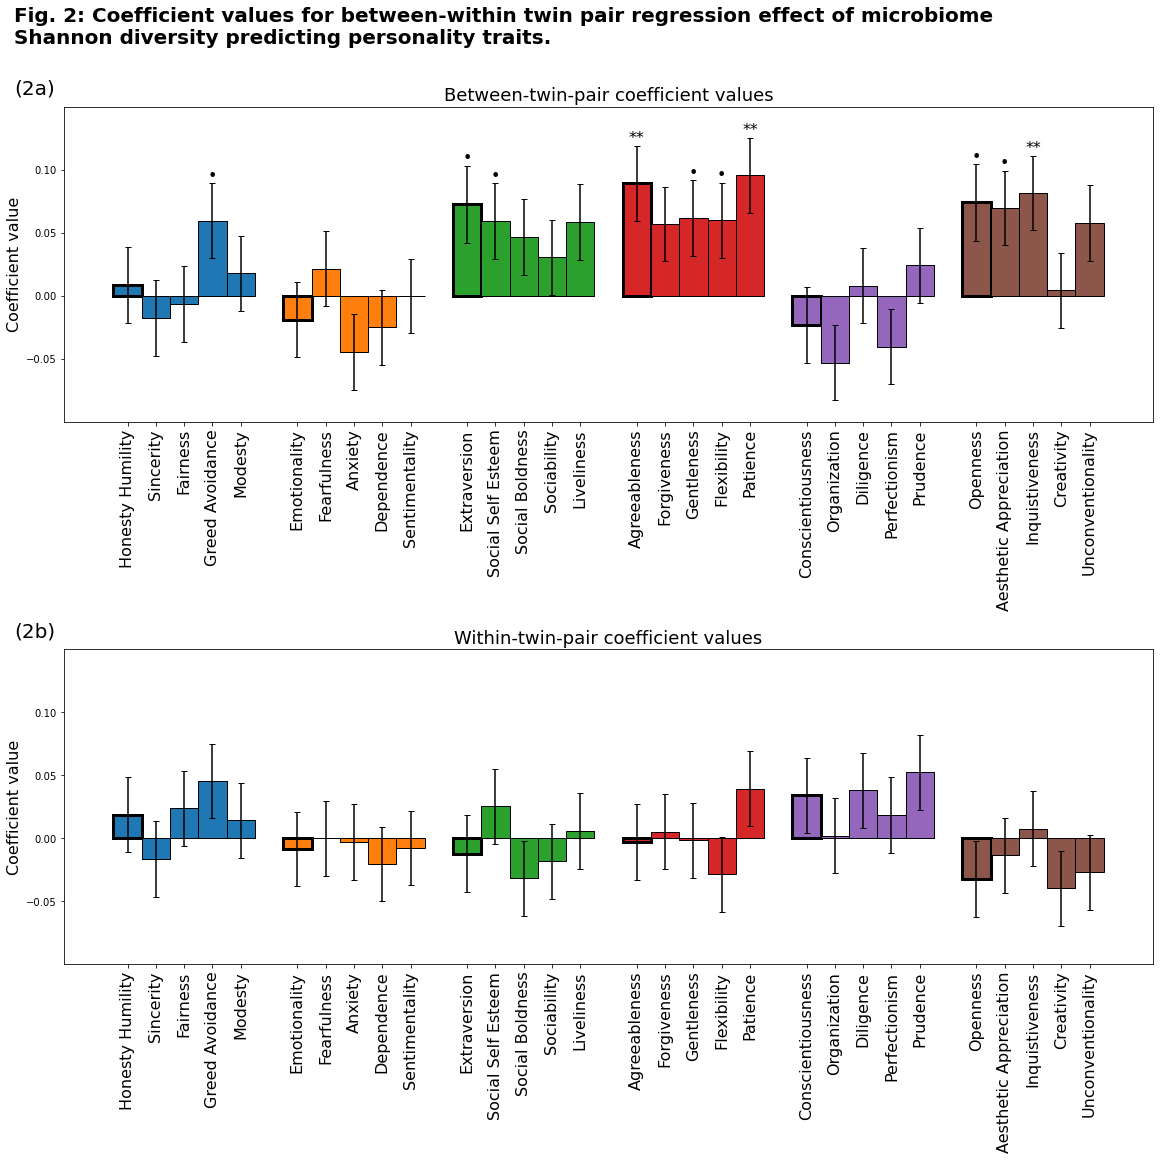

In [21]:
## Plot results from model (2) analyses
## Separated by MZ and DZ twins

csfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"


HEXACO_var_names = ['Honesty Humility', 'Sincerity', 'Fairness', 'Greed Avoidance', 'Modesty', \
                       'Emotionality', 'Fearfulness', 'Anxiety', 'Dependence', 'Sentimentality', \
                       'Extraversion', 'Social Self Esteem', 'Social Boldness', 'Sociability', 'Liveliness', \
                       'Agreeableness', 'Forgiveness', 'Gentleness', 'Flexibility', 'Patience', \
                       'Conscientiousness', 'Organization', 'Diligence', 'Perfectionism', 'Prudence', \
                       'Openness', 'Aesthetic Appreciation', 'Inquistiveness', 'Creativity', 'Unconventionality']

stderr_vals_BW = [list(twin_pair_results['all_B_StdErr']), list(twin_pair_results['all_W_StdErr'])]

fig, ax = plt.subplots(2,figsize=(16,16), layout="constrained")

for bw, var_str in enumerate(['all_B', 'all_W']):
#     print(var_str)
    
    Coefficient_var_str = var_str + '_Coefficient'
    p_var_str = var_str + '_p'
    
    
#     ax = fig.add_axes([0,0,1,1])

    if (var_str == 'all_B'):
        ax[bw].set_title('Between-twin-pair coefficient values', **csfont, fontsize = 18)
    elif (var_str == 'all_W'):
        ax[bw].set_title('Within-twin-pair coefficient values', **csfont, fontsize = 18)
    


    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

    i = 0
    for itr in range(0, len(twin_pair_results[Coefficient_var_str]) + 5):
        if ((itr + 1) % 6 != 0):
            if (i % 5 == 0):
                rect = ax[bw].bar(0.25*itr, twin_pair_results[Coefficient_var_str][i], color = colors[int(i / 5)], width = 0.25, edgecolor='black', yerr = stderr_vals_BW[bw][i], capsize=3, linewidth=3)
            else:
                rect = ax[bw].bar(0.25*itr, twin_pair_results[Coefficient_var_str][i], color = colors[int(i / 5)], width = 0.25, edgecolor='black', yerr = stderr_vals_BW[bw][i], capsize=3)
            i += 1

    label_locs = np.concatenate([np.arange(0, 1.25, 0.25), np.arange(1.5, 2.75, 0.25), np.arange(3, 4.25, 0.25), np.arange(4.5, 5.75, 0.25), np.arange(6, 7.25, 0.25), np.arange(7.5, 8.75, 0.25)])
    ax[bw].set_xticks(label_locs, HEXACO_var_names, rotation = 'vertical', fontsize=16)
    ax[bw].set_yticks(np.arange(-0.05, 0.15, 0.05), fontsize=20)
    ax[bw].set_ylabel('Coefficient value', fontsize = 16)
    ax[bw].set_ylim([-0.1, 0.15])


    for i, rect in enumerate(ax[bw].patches):
        symbol = ''
        if (twin_pair_results[p_var_str][i] <= 0.001):
            symbol = '***'
        elif (twin_pair_results[p_var_str][i] <= 0.05/6):
            symbol = '**'
        elif (twin_pair_results[p_var_str][i] <= 0.05):
            symbol = '•'

        if (rect.get_height() >= 0):
            ax[bw].text(rect.get_x() + rect.get_width() / 2.0, rect.get_height() + stderr_vals_BW[bw][i], symbol, ha='center', va='bottom', fontsize=16)
        else:
            ax[bw].text(rect.get_x() + rect.get_width() / 2.0, rect.get_height() - 0.02 - stderr_vals_BW[bw][i], symbol, ha='center', va='bottom', fontsize=16)
    
    if (bw == 0):
        ax[bw].text(-1, 0.2, 'Fig. 2: Coefficient values for between-within twin pair regression effect of microbiome \nShannon diversity predicting personality traits.', fontsize=20, fontweight='bold')
        ax[bw].text(-1, 0.16, '(2a)', fontsize=20)
    else:
        ax[bw].text(-1, 0.16, '(2b)', fontsize=20)



fig.savefig('20230321_DiversityRegressions_BW.png', bbox_inches='tight', dpi=400)



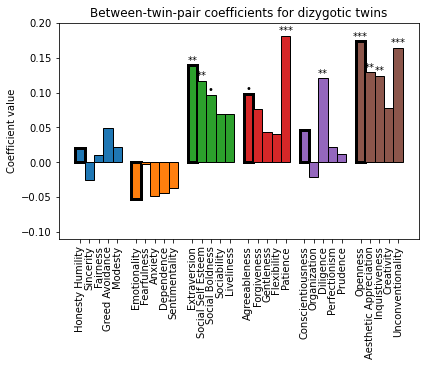

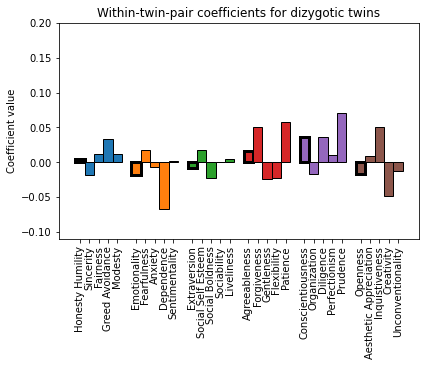

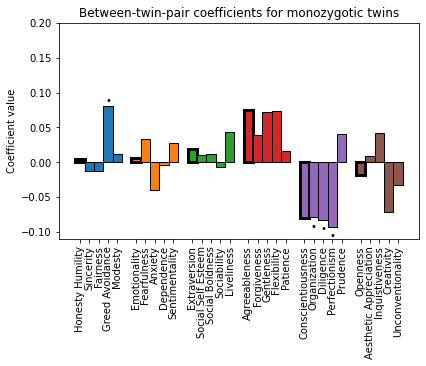

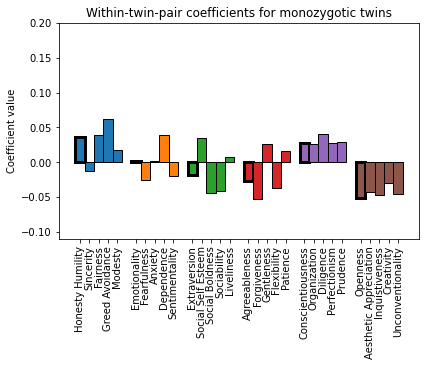

In [12]:
# ## Plot results from model (2) analyses
# ## Separated by MZ and DZ twins

# HEXACO_var_names = ['Honesty Humility', 'Sincerity', 'Fairness', 'Greed Avoidance', 'Modesty', \
#                        'Emotionality', 'Fearfulness', 'Anxiety', 'Dependence', 'Sentimentality', \
#                        'Extraversion', 'Social Self Esteem', 'Social Boldness', 'Sociability', 'Liveliness', \
#                        'Agreeableness', 'Forgiveness', 'Gentleness', 'Flexibility', 'Patience', \
#                        'Conscientiousness', 'Organization', 'Diligence', 'Perfectionism', 'Prudence', \
#                        'Openness', 'Aesthetic Appreciation', 'Inquistiveness', 'Creativity', 'Unconventionality']

# for var_str in ['DZ_B', 'DZ_W', 'MZ_B', 'MZ_W']:
# #     print(var_str)
    
#     Coefficient_var_str = var_str + '_Coefficient'
#     p_var_str = var_str + '_p'
    
#     fig = plt.figure(figsize=(5, 3))
#     ax = fig.add_axes([0,0,1,1])

#     if (var_str == 'DZ_B'):
#         plt.title('Between-twin-pair coefficients for dizygotic twins')
#     elif (var_str == 'DZ_W'):
#         plt.title('Within-twin-pair coefficients for dizygotic twins')
#     elif (var_str == 'MZ_B'):
#         plt.title('Between-twin-pair coefficients for monozygotic twins')
#     elif (var_str == 'MZ_W'):
#         plt.title('Within-twin-pair coefficients for monozygotic twins')



#     colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

#     i = 0
#     for itr in range(0, len(twin_pair_results[Coefficient_var_str]) + 5):
#         if ((itr + 1) % 6 != 0):
#             if (i % 5 == 0):
#                 rect = ax.bar(0.25*itr, twin_pair_results[Coefficient_var_str][i], color = colors[int(i / 5)], width = 0.25, edgecolor='black', linewidth=3)
#             else:
#                 rect = ax.bar(0.25*itr, twin_pair_results[Coefficient_var_str][i], color = colors[int(i / 5)], width = 0.25, edgecolor='black')
#             i += 1

#     label_locs = np.concatenate([np.arange(0, 1.25, 0.25), np.arange(1.5, 2.75, 0.25), np.arange(3, 4.25, 0.25), np.arange(4.5, 5.75, 0.25), np.arange(6, 7.25, 0.25), np.arange(7.5, 8.75, 0.25)])
#     plt.xticks(label_locs, HEXACO_var_names, rotation = 'vertical', fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.ylabel('Coefficient value', fontsize = 10)
#     plt.ylim([-0.11, 0.2])


#     for i, rect in enumerate(ax.patches):
#         symbol = ''
#         if (twin_pair_results[p_var_str][i] <= 0.001):
#             symbol = '***'
#         elif (twin_pair_results[p_var_str][i] <= 0.05/6):
#             symbol = '**'
#         elif (twin_pair_results[p_var_str][i] <= 0.05):
#             symbol = '•'

#         if (rect.get_height() >= 0):
#             plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), symbol, ha='center', va='bottom', fontsize=10)
#         else:
#             plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height() - 0.02, symbol, ha='center', va='bottom', fontsize=10)


#     plt.savefig('20220829_DiversityRegressions_' + var_str, bbox_inches='tight', dpi=100)



In [75]:
## Holm-Bonferroni

p_values = [0.0429, 0.018, 0.0479, 0.003022, 0.0397, 0.0448, 0.00139, 0.01465, 0.0184, 0.00601]
sorted_p_values = np.sort(p_values)
print(sorted_p_values)

m = len(sorted_p_values)
for i in range(0, len(sorted_p_values)):
    if (sorted_p_values[i] <= 0.05 / (m - i)):
        print("Reject H0: ", sorted_p_values[i], " < ", 0.05 / (m - i), " = alpha")
    else:
        print("Accept H0: ", sorted_p_values[i], " < ", 0.05 / (m - i), " = alpha")
len(p_values)

[0.00139  0.003022 0.00601  0.01465  0.018    0.0184   0.0397   0.0429
 0.0448   0.0479  ]
Reject H0:  0.00139  <  0.005  = alpha
Reject H0:  0.003022  <  0.005555555555555556  = alpha
Reject H0:  0.00601  <  0.00625  = alpha
Accept H0:  0.01465  <  0.0071428571428571435  = alpha
Accept H0:  0.018  <  0.008333333333333333  = alpha
Accept H0:  0.0184  <  0.01  = alpha
Accept H0:  0.0397  <  0.0125  = alpha
Accept H0:  0.0429  <  0.016666666666666666  = alpha
Accept H0:  0.0448  <  0.025  = alpha
Reject H0:  0.0479  <  0.05  = alpha


10

In [76]:
p_values = [0.0429, 0.018, 0.0479, 0.003022, 0.0397, 0.0448, 0.00139, 0.01465, 0.0184, 0.00601]
for p in p_values:
    if (p < 0.05 / 6):
        print("reject")
    else:
        print("accept")

accept
accept
accept
reject
accept
accept
reject
accept
accept
reject
